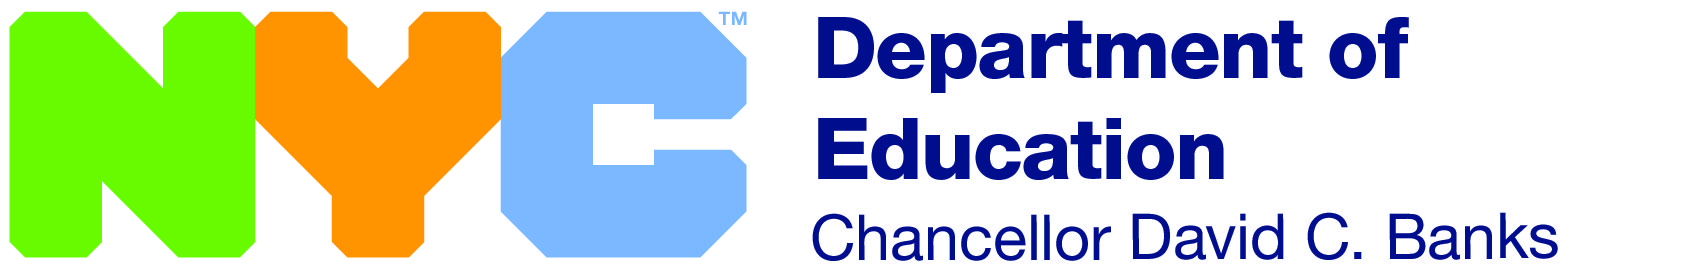

## Project: Analyzing NYC High School Data

### Introduction:

In this project our goal is to see how students score on the SAT test and what possibly can impact their scores. The SAT test which stands for Scholastic Aptitude Test is a final test high school students take before applying to college. Colleges take into account the scores on the SAT test as well as their overall grades in high school to determine if they will accept the student to enroll in their college.  

We can learn a few different things. For example:

* High school students take the SAT, so we'll want to focus on high schools.
* New York City is made up of five boroughs, which are distinct regions.
* Each school in New York City has a unique code called a DBN or district borough number.

Aggregating data by district allows us to use the district mapping data to plot borough-by-borough differences.
With this information we can also see how other factors impact a students success. For example: 

* How does school safety impact test results
* How does AP class students perform on SAT tests. 
* How does class size impact test scores. 

There are many ways we can explore the data. 

The source of all this data is not found in one place. I will have to compile many different datasets to complete the scope of my project. 

Here is an extensive list of all the data sets used: 

* ap_2010.csv - [Data on AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e)
* class_size.csv - [Data on class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
* demographics.csv - [Data on demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j)
* graduation.csv - [Data on graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a)
* hs_directory.csv - [A directory of high schools](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2)
* sat_results.csv - [Data on SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)
* survey_all.txt - [Data on surveys from all schools](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)
* survey_d75.txt - [Data on surveys from New York City district 75](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)


### Read in the data:

In [421]:
import pandas as pd
import numpy
import re
import warnings
warnings.filterwarnings("ignore")

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys:

In [422]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Data Cleaning: 

#### Adding DBN columns:

In [423]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#### Convert columns to numeric:

In [424]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### Condenseing datasets:

In [425]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### Convert AP scores to numeric:

In [426]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

#### Combining the datasets:

In [427]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#### Add a school district column for mapping:

In [428]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Finding correlations: 

Now that the cleaning of the data is completed we can move forward with exploring the data and looking for correlations. 
Here is the Data dictionary for the data we will be looking at for the surveys. 

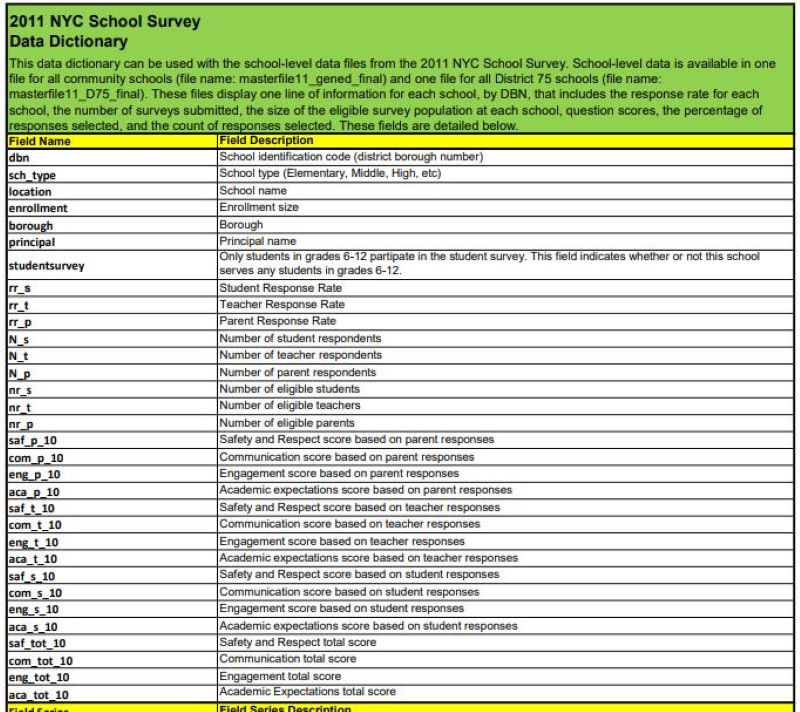

In [429]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In [430]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [431]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('fivethirtyeight')

survey_corr = correlations[survey_fields].sort_values()
print(survey_corr)

com_p_11     -0.115073
rr_t         -0.023386
eng_p_11      0.020254
aca_p_11      0.035155
eng_t_11      0.036906
rr_p          0.047925
com_tot_11    0.077310
com_t_11      0.082419
eng_tot_11    0.100102
saf_p_11      0.122913
aca_t_11      0.132348
com_s_11      0.187370
aca_tot_11    0.190966
eng_s_11      0.213822
rr_s          0.232199
N_t           0.291463
saf_t_11      0.313810
saf_tot_11    0.318753
saf_s_11      0.337639
aca_s_11      0.339435
N_p           0.421530
N_s           0.423463
Name: sat_score, dtype: float64


<Axes: >

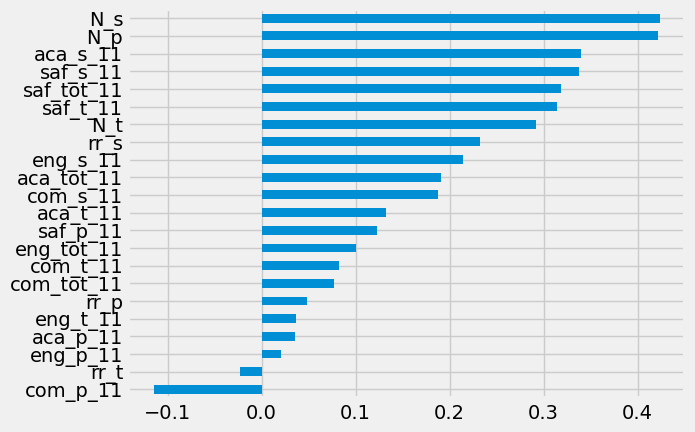

In [432]:
survey_corr.plot.barh()

* Safety and respect teachers = saf_t_11   =   0.313810
* Safety and respect total    = saf_tot_11  =  0.318753
* Safety and respect student  = saf_s_11   =   0.337639
* Academic expectations Students = aca_s_11      0.339435
* Number of Teachers   = N_t     =      0.291463
* Number of Parents    = N_p     =      0.421530
* Number of Students   = N_s     =      0.423463

The safety and respect have a high correlation across all survey participants.
The academic expectations scored high amongst students. 
Surprisingly the correlation of Teachers is lower then students and parents. 
I would have expected it to be higher. 

### Exploring Safety and SAT Scores:

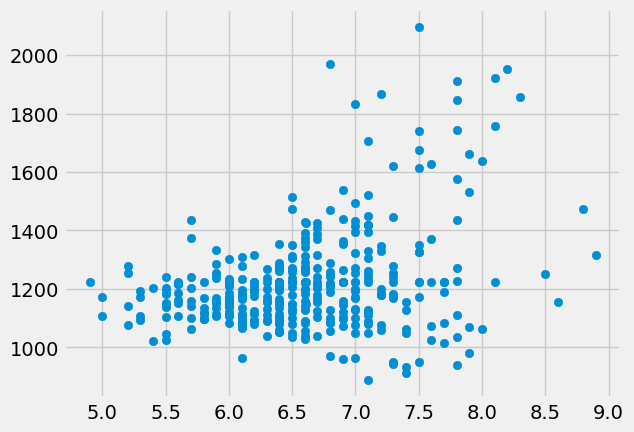

In [433]:
plt.scatter(combined['saf_s_11'],combined['sat_score'])
plt.show()

In [434]:
combined['saf_s_11'].mean()

6.611666666666666

In [435]:
combined['sat_score'].mean()

1223.4388059701494

### Notes:

The average safety rating is 6.6 with the average SAT score being 1223. 
The safety does show a slight impact to score but not as much as one would have assumed. 
The safety range of 6.6 to 8.4 seems to capture the highest 
SAT scores. After 8.4 it falls off.

### Lets see how safety impacts each borough in NYC:

In [436]:
combined_boro = combined.groupby('boro').agg(numpy.mean)

combined_boro['saf_s_11'].sort_values(ascending=False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

In [437]:
combined_boro[['saf_s_11', 'saf_t_11', 'saf_p_11', 'saf_tot_11' ]].sort_values('saf_tot_11', ascending=False)

,saf_s_11,saf_t_11,saf_p_11,saf_tot_11
boro,,,,
Manhattan,6.831370,7.287778,8.288889,7.473333
Queens,6.721875,7.365625,8.098437,7.387500
Bronx,6.606577,7.026882,8.346237,7.322581
Staten Island,6.530000,7.210000,7.800000,7.200000
Brooklyn,6.370755,6.985849,8.036792,7.129245


### Notes: 

The borough with the highest total safety score is Manhattan. The lowest appears to be brooklyn. 

Queens has the highest teacher safety score with brooklyn again being the lowest. 

### Exploring Race and SAT Scores

In [438]:
race_grouped = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
race_correlations = correlations[race_grouped]

print (race_correlations)

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64


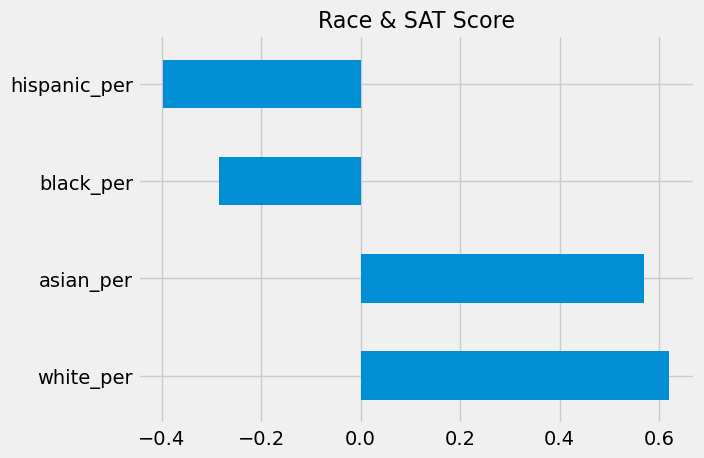

In [439]:
race_correlations.plot.barh()
plt.title('Race & SAT Score', fontsize=16)
plt.show()

### Notes: 

Schools with a higher percentage of white and asian students score better then schools with black or hispanic students. 

### Lets see what it looks like for for the correlation of population of hispanic students and SAT Scores:

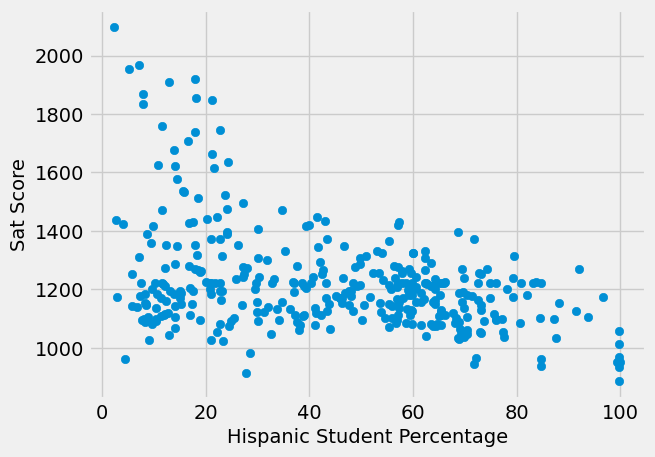

In [440]:
plt.scatter(combined['hispanic_per'],combined['sat_score'])
plt.ylabel('Sat Score', fontsize=14)
plt.xlabel('Hispanic Student Percentage', fontsize=14)
plt.show()

In [441]:
#pulling schools with over 95% hispanic student population

hispanic_95 = combined[combined['hispanic_per'] > 95]

print(hispanic_95['SCHOOL NAME'],hispanic_95['boro'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object 44     Manhattan
82     Manhattan
89     Manhattan
125        Bronx
141        Bronx
176        Bronx
253     Brooklyn
286       Queens
Name: boro, dtype: object


### Notes: 

* It seems the higher percentage of hispanic students the lower the sat scores. 

* After researching each school on the top 8 it seems they all cater to spanish students. Either american or those who have immigrated to NYC. The other common factor seems to be most of the students are from economically disadvantaged families. 


In [442]:
hispanic_10 = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

print(hispanic_10['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Notes: 

All of these schools are high rated schools in the 5 boroughs. These are typically the schools the brightest students attend that require high grade scores to be accepted. 

These schools also have a very low percentage of hispanic students. 

### Exploring Gender and SAT Scores:

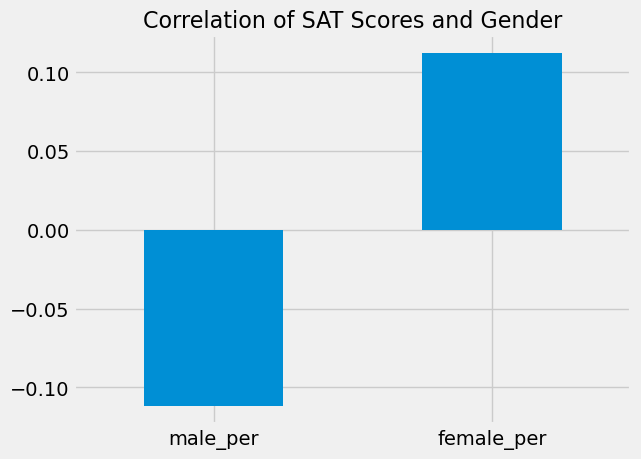

In [443]:
gender_grouped = ['male_per', 'female_per']
gender_corr = correlations[gender_grouped]

gender_corr.plot.bar()
plt.title('Correlation of SAT Scores and Gender', fontsize=16)
plt.xticks(rotation=0)
plt.show()

### Notes: 

It seems females have a positive correlationa and males have a negative correlation. Neither correlations are strong to where you can interpret any external impacts. 

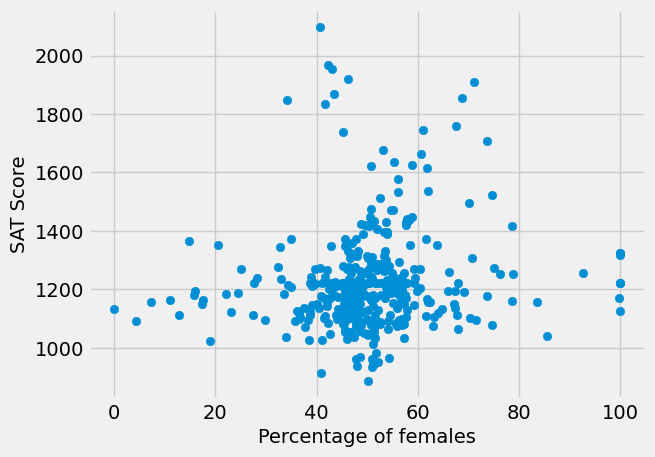

In [444]:
plt.scatter(combined['female_per'], combined['sat_score'])
plt.ylabel('SAT Score', fontsize=14)
plt.xlabel('Percentage of females', fontsize=14)
plt.show()

### Notes: 

The only interesting observation is that the female gender seem to perform better in a co-ed enviroment. The schools with very little or many females dont seem to perform as well. This could be based on the school and education. The best schools in NYC tend to be a co-ed enivornment. 

In [445]:
#pulling female percentage in top schools

female_60 = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

print(female_60['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Notes: 

The 5 schools listed are again for top performing students. These are schools where the students with high elementary grades will attend. 

### Exploring AP Scores vs. SAT Scores:

In [446]:
combined['ap_per'] = round(combined['AP Test Takers '] / combined['total_enrollment'] * 100)

print(combined['ap_per'].head())

0    31.0
1    10.0
2     3.0
3    35.0
4    16.0
Name: ap_per, dtype: float64


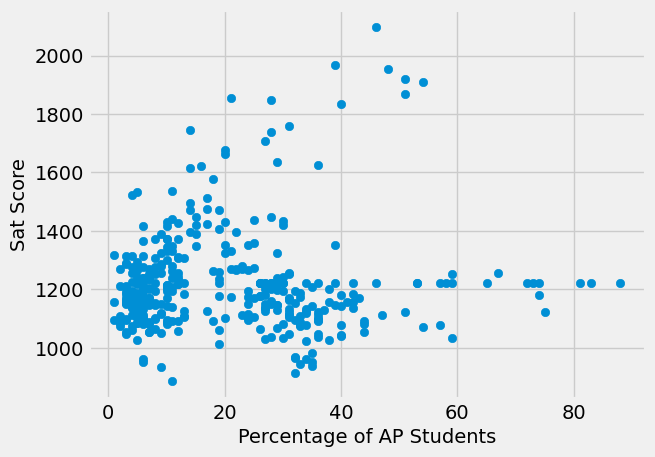

In [447]:
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.ylabel('Sat Score', fontsize=14)
plt.xlabel('Percentage of AP Students',fontsize=14)
plt.show()

### Notes: 

There does not appear to be a strong correlation with AP students and Sat Scores. 

### Class size impact on sat scores:

In [448]:
pd.set_option('display.max_columns', None)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,153.45,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%,1.0,88.000000,4.000000,22.564286,18.500000,26.571429,0.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,0.0,88.6,422,,,,,,,,32,33,50,98,79,80,50,94.0,22.3,105.0,24.9,34,35,59,14.0,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0,01M292,Henry Street School for International Studies,Manhattan,M056,212-406-9411,212-406-9417,6,12,0,12.0,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,0,0,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Chinese Language and Culture, Spanish Literatu...","Chinese (Mandarin), Spanish","Math through Card Play; Art, Poetry/Spoken Wor...",Basketball,Softball,Soccer,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,0,0,United Nations,0,0,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-7

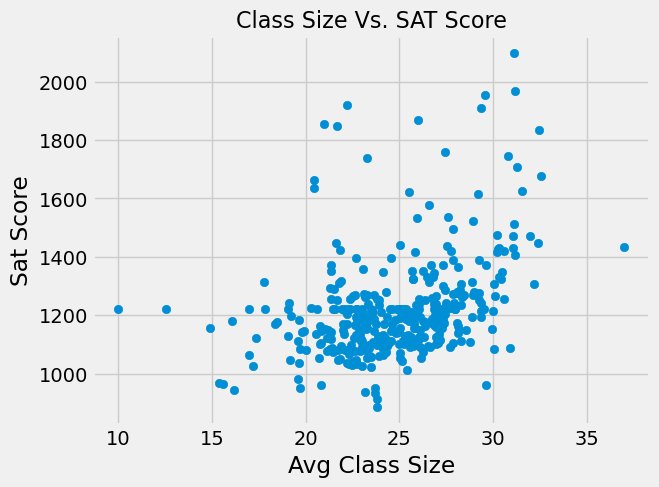

In [449]:
plt.scatter(combined['AVERAGE CLASS SIZE'],combined['sat_score'])
plt.xlabel('Avg Class Size')
plt.ylabel('Sat Score')
plt.title('Class Size Vs. SAT Score', fontsize=16)
plt.show()

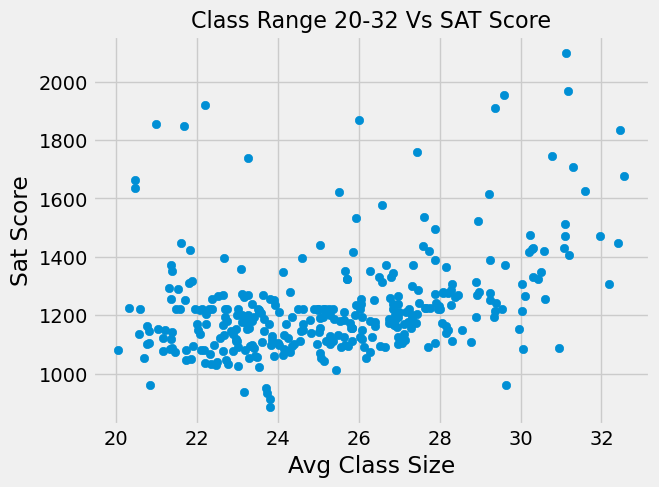

In [450]:
center = combined[(combined['AVERAGE CLASS SIZE'] > 20) & (combined['AVERAGE CLASS SIZE'] < 34)]

plt.scatter(center['AVERAGE CLASS SIZE'], center['sat_score'])
plt.xlabel('Avg Class Size')
plt.ylabel('Sat Score')
plt.title('Class Range 20-32 Vs SAT Score', fontsize=16)
plt.show()

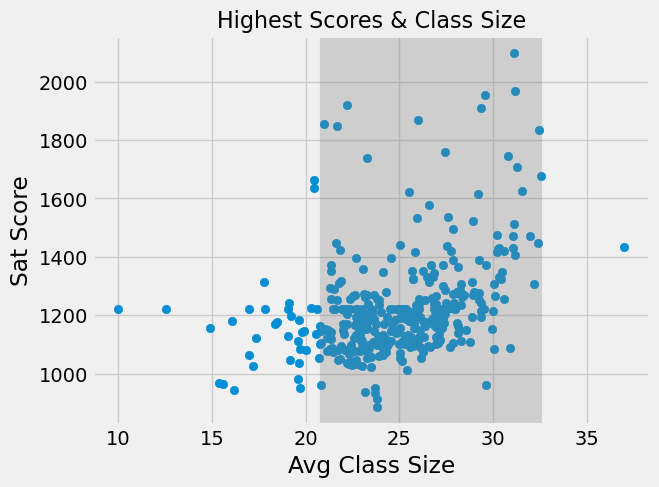

In [451]:
plt.scatter(combined['AVERAGE CLASS SIZE'],combined['sat_score'])
plt.axvline(x= 26.7, c='grey', linewidth= 160, alpha=0.3)
plt.xlabel('Avg Class Size')
plt.ylabel('Sat Score')
plt.title('Highest Scores & Class Size', fontsize=16)
plt.show()

### Notes: 

As we can see there is not a large correlation betwen class size and Sat Scores. Smaller class sizes do not seem to perform better on the Sat's. 
No class size below 20 scores above 1400. 

The large portion of high scores seem to be in a class size range of 21-33 students. 

### Differences between parent, teacher, and student responses to surveys by boro.

In this portion I will analyze the difference between parent, teacher, and student responses to each topic in the surveys. I will split them up by borough. 

I will start with the Safety and Respect Score by borough. This is a copy and paste from earlier in the project but for the sake of having it all in one section will be easier to look back on.

In [452]:
print("\033[1m" + 'Safety and Respect Score' + "\033[0m" )
combined_boro[['saf_s_11', 'saf_t_11', 'saf_p_11', 'saf_tot_11' ]].sort_values('saf_tot_11', ascending=False)

Safety and Respect Score


,saf_s_11,saf_t_11,saf_p_11,saf_tot_11
boro,,,,
Manhattan,6.831370,7.287778,8.288889,7.473333
Queens,6.721875,7.365625,8.098437,7.387500
Bronx,6.606577,7.026882,8.346237,7.322581
Staten Island,6.530000,7.210000,7.800000,7.200000
Brooklyn,6.370755,6.985849,8.036792,7.129245


### Notes: 

To recap: Students seem to respond with the lowest scores. Teachers come in second and parents are the highest. The borough with the highest total safety score is Manhattan and the lowest appears to be Brooklyn. Queens has the highest teacher safety score with brooklyn again being the lowest. 

### Now I will look at the Survey fields:

The survey fields we will look at are: 

* Communication 
* Engagement
* Academic Expectation 


In [453]:
print("\033[1m"  + 'Communication Score'+ "\033[0m" )
combined_boro[['com_s_11', 'com_t_11', 'com_p_11', 'com_tot_11' ]].sort_values('com_tot_11', ascending=False)

Communication Score


,com_s_11,com_t_11,com_p_11,com_tot_11
boro,,,,
Staten Island,6.070000,7.140000,7.390000,6.870000
Queens,6.090625,6.789062,7.476562,6.779687
Bronx,6.093492,6.397849,7.805376,6.765591
Manhattan,6.179883,6.432222,7.577778,6.728889
Brooklyn,6.028302,6.509434,7.600000,6.715094


In [454]:
print("\033[1m"  + 'Engagement Score'+ "\033[0m" )
combined_boro[['eng_s_11', 'eng_t_11', 'eng_p_11', 'eng_tot_11' ]].sort_values('eng_tot_11', ascending=False)

Engagement Score


,eng_s_11,eng_t_11,eng_p_11,eng_tot_11
boro,,,,
Staten Island,6.780000,7.390000,7.460000,7.200000
Queens,6.664062,7.139062,7.425000,7.073437
Bronx,6.630326,6.884946,7.639785,7.046237
Manhattan,6.644895,6.963333,7.465556,7.021111
Brooklyn,6.549057,6.979245,7.516981,7.016038


In [455]:
print("\033[1m"  + 'Academic Expectation Score'+ "\033[0m" )
combined_boro[['aca_s_11', 'aca_t_11', 'aca_p_11', 'aca_tot_11' ]].sort_values('aca_tot_11', ascending=False)

Academic Expectation Score


,aca_s_11,aca_t_11,aca_p_11,aca_tot_11
boro,,,,
Staten Island,7.330000,7.860000,7.620000,7.610000
Bronx,7.418079,7.427957,7.947312,7.598925
Queens,7.410938,7.668750,7.685937,7.593750
Manhattan,7.408475,7.472222,7.786667,7.556667
Brooklyn,7.313208,7.497170,7.789623,7.535849


According to the Communication Score: 

* The borough with the highest total is Staten Island
* Students ranked Manhattan as the highest. 
* Teachers ranked Staten Island as the highest
* Parents ranked the Bronx as the highest

According to the Engagement Score: 

* The borough with the highest total is Staten Island
* Students ranked Staten Island as the highest. 
* Teachers ranked Staten Island as the highest
* Parents ranked the Bronx as the highest

According to the Academic Expectation Score: 

* The borough with the highest total is Staten Island
* Students ranked Bronx as the highest. 
* Teachers ranked Staten Island as the highest
* Parents ranked the Bronx as the highest


### Creating a scoring system for schools based on SAT score and other attributes:


I will create a scoring system for schools based on Sat Score, Total percentage of graduates, and survey total scores. 
First I will combined the totals for all the survey scores. Second I will take the percentage of graduates drop the percent symbol so I can convert it easier to a grading system. 

Each category will have a seperate rank and then a total rank. 


In [456]:
#scoring the survey results 

combined['survey_score_total'] = round(combined['aca_tot_11'] + combined['eng_tot_11'] + combined['com_tot_11'] + combined['saf_tot_11'], 2)

combined['survey_score_total'] = round(combined['survey_score_total'] /4, 2)

print (combined['survey_score_total'].describe())
print (combined['survey_score_total'].head())

count    363.000000
mean       7.166942
std        0.529937
min        5.000000
25%        6.850000
50%        7.150000
75%        7.520000
max        8.800000
Name: survey_score_total, dtype: float64
0    6.62
1    6.75
2    8.02
3    6.68
4    7.30
Name: survey_score_total, dtype: float64


In [457]:
#function for school survey rank system and results

def score_grade(x): 
    if 8.01 <= x < 10.00:
        return 'A'
    elif 6.01 <= x < 8.01:
        return 'B'
    elif 5.01 <= x < 6.01:
        return 'C'
    else: 
        return 'D'
    
combined['survey_score_ranking'] = combined['survey_score_total'].apply(lambda x: score_grade(x)) 
display(combined['survey_score_ranking'].value_counts())
    

B    329
A     27
C      6
D      1
Name: survey_score_ranking, dtype: int64

In [458]:
print (combined['Total Grads - % of cohort'].describe())
print (combined['Total Grads - % of cohort'].info())
print (combined['Total Grads - % of cohort'].head())

count     363
unique    224
top         0
freq       53
Name: Total Grads - % of cohort, dtype: int64
<class 'pandas.core.series.Series'>
Int64Index: 363 entries, 0 to 362
Series name: Total Grads - % of cohort
Non-Null Count  Dtype 
--------------  ----- 
363 non-null    object
dtypes: object(1)
memory usage: 5.7+ KB
None
0    55.1%
1    42.7%
2    77.8%
3      56%
4     100%
Name: Total Grads - % of cohort, dtype: object


In [459]:
def replaced(element):
    x= str(element).replace('s','0.0').replace('%','')
    x1 = float(x)
    return x1

combined['Total Grads - % of cohort'] = combined['Total Grads - % of cohort'].apply(replaced)

combined['Total Grads - % of cohort'].head()

0     55.1
1     42.7
2     77.8
3     56.0
4    100.0
Name: Total Grads - % of cohort, dtype: float64

In [460]:
#function for school graduation rate rank system and results

def score_grads(x): 
    if 80.00 <= x < 100.00:
        return 'A'
    elif 60.00 <= x < 80.00:
        return 'B'
    elif 40.00 <= x < 60.00:
        return 'C'
    else: 
        return 'D'

combined['graduation_ranking'] = combined['Total Grads - % of cohort'].apply(lambda x: score_grads(x)) 
display(combined['graduation_ranking'].value_counts())

B    131
D     80
A     79
C     73
Name: graduation_ranking, dtype: int64

### Notes: 

Based on the ranking system I created: 

For the __Survey Score Rank__ system I am not surprised by the results I assumed most would of fell around a grade B rank. 

For the __Graduation Rank__ I am actually surprised of how many schools are below an 80% graduation rate. If I was a parent or an employee of the Board of Education I would be concerned with the Schools that have a lower than 80% graduation rate. 

Lets continue with ranking the SAT score: 

In [461]:
print (combined['sat_score'].describe())

count     363.000000
mean     1223.438806
std       178.223775
min       887.000000
25%      1113.000000
50%      1193.000000
75%      1266.500000
max      2096.000000
Name: sat_score, dtype: float64


In [462]:
#ranking Sat score results

def score_sat(x): 
    if 1576.00 <= x < 2100.00:
        return 'A'
    elif 1050.00 <= x < 1576.00:
        return 'B'
    elif 526.00 <= x < 1050.00:
        return 'C'
    else: 
        return 'D'

combined['sat_score_grade'] = combined['sat_score'].apply(lambda x: score_sat(x)) 
print(combined['sat_score_grade'])
display(combined['sat_score_grade'].value_counts())

0      B
1      B
2      B
3      B
4      A
      ..
358    B
359    C
360    B
361    B
362    B
Name: sat_score_grade, Length: 363, dtype: object


B    317
C     26
A     20
Name: sat_score_grade, dtype: int64

In [463]:
#verifying how the columns look in the dataframe

combined[['sat_score_grade','graduation_ranking','survey_score_ranking']]

,sat_score_grade,graduation_ranking,survey_score_ranking
0,B,C,B
1,B,C,B
2,B,B,A
3,B,C,B
4,A,D,B
...,...,...,...
358,B,B,B
359,C,B,B
360,B,C,B
361,B,A,A


In [464]:
#creating total rank column 

def total_score(x): 
    if x == 'A':
        return 4
    elif x == 'B':
        return 3
    elif x == 'C':
        return 2
    else: 
        return 1
    
combined['total_ranking']=combined['sat_score_grade'].apply(lambda x: total_score(x)) + combined['graduation_ranking'].apply(lambda x: total_score(x)) + combined['survey_score_ranking'].apply(lambda x: total_score(x))
combined['total_ranking']= round(combined['total_ranking'] /3)
print(combined['total_ranking'].value_counts())

def total_back(x): 
    if x == 4.0:
        return 'A'
    elif x == 3.0:
        return 'B'
    elif x == 2.0:
        return 'C'
    else: 
        return 'D'

combined['total_ranking'] = combined['total_ranking'].apply(lambda x: total_back(x))
print(combined['total_ranking'].value_counts())

3.0    262
2.0     78
4.0     23
Name: total_ranking, dtype: int64
B    262
C     78
A     23
Name: total_ranking, dtype: int64


In [465]:
staten_ranks = combined['total_ranking'][combined['boro'] == 'Staten Island'].value_counts()
manhattan_ranks = combined['total_ranking'][combined['boro'] == 'Manhattan'].value_counts()
queens_ranks = combined['total_ranking'][combined['boro'] == 'Queens'].value_counts()
brooklyn_ranks = combined['total_ranking'][combined['boro'] == 'Brooklyn'].value_counts()
bronx_ranks = combined['total_ranking'][combined['boro'] == 'Bronx'].value_counts()

print('School Rankings Per Borough')
print()
print ('Staten Island')
print(staten_ranks)
print ('Manhattan')
print(manhattan_ranks)
print ('Queens')
print(queens_ranks)
print ('Brooklyn')
print(brooklyn_ranks)
print ('Bronx')
print(bronx_ranks)


School Rankings Per Borough

Staten Island
B    8
C    1
A    1
Name: total_ranking, dtype: int64
Manhattan
B    66
C    15
A     9
Name: total_ranking, dtype: int64
Queens
B    47
C    14
A     3
Name: total_ranking, dtype: int64
Brooklyn
B    65
C    33
A     8
Name: total_ranking, dtype: int64
Bronx
B    76
C    15
A     2
Name: total_ranking, dtype: int64


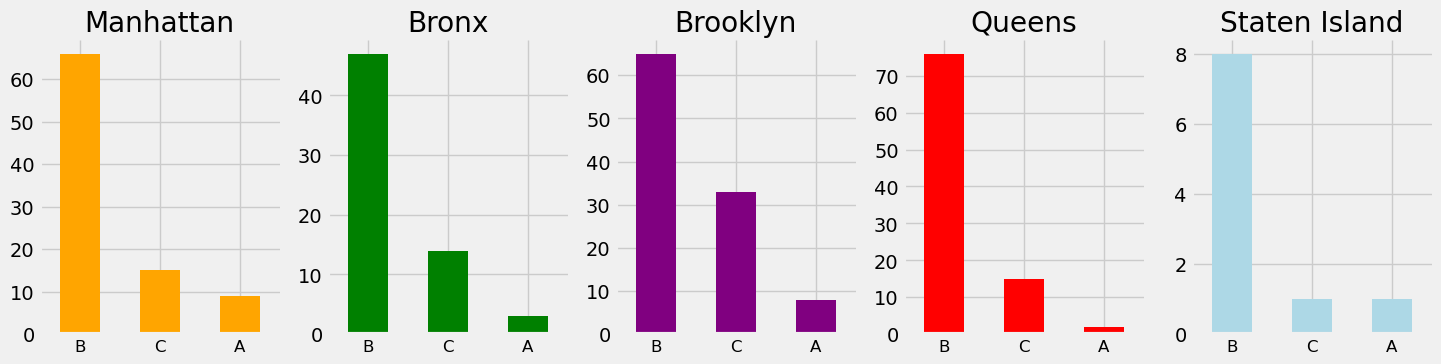

In [466]:
fig = plt.figure(figsize=(16, 8))

ax1 = plt.subplot(2, 5, 1)
ax2 = plt.subplot(2, 5, 2)
ax3 = plt.subplot(2, 5, 3)
ax4 = plt.subplot(2, 5, 4)
ax5 = plt.subplot(2, 5, 5)

axes = [ax1, ax2, ax3, ax4, ax5]

for ax in axes[:4]:
    ax.set_yticks([0,10,20,30,40,50,60,70])

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
c_list = ['orange', 'green', 'purple', 'red', 'lightblue']


manhattan_ranks.plot(kind='bar', ax=ax1, color=c_list[0])
ax1.set_title('Manhattan')
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12,rotation=0)

queens_ranks.plot(kind='bar', ax=ax2, color=c_list[1])
ax2.set_title('Bronx')
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12,rotation=0)


brooklyn_ranks.plot(kind='bar', ax=ax3, color=c_list[2])
ax3.set_title('Brooklyn')
ax3.set_xticklabels(ax3.get_xticklabels(), fontsize=12,rotation=0)


bronx_ranks.plot(kind='bar', ax=ax4, color=c_list[3])
ax4.set_title('Queens')
ax4.set_xticklabels(ax4.get_xticklabels(), fontsize=12,rotation=0)


staten_ranks.plot(kind='bar', ax=ax5, color=c_list[4])
ax5.set_title('Staten Island')
ax5.set_xticklabels(ax5.get_xticklabels(), fontsize=12, rotation=0)

plt.show()
    

### Observations: 

* As we can see by the graph above a __B Ranked__ School has the highest majority of schools in every borough. 
* Brooklyn have the most __C Ranked__ Schools out of all of the boroughs. 
* Manhattan has the most amount of __A Ranked__ schools. 

Other interesting findings: 

* Even though Brooklyn has the highest C ranked schools they are also second with the most amount of A Ranked schools. 
* Staten Island has the least amount of schools in this dataset. Staten Island is the least populated borough in NYC so this makes sense. 


### Looking at property values in the 5 Boroughs: 

If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have the best schools. We will gather sales data for the years 2011-2012 based on the datasets we have from the board of education. 

I discovered a dataset on [Kaggle](https://www.kaggle.com/datasets/johnshuford/new-york-city-property-sales) that had every sale in every borough from 2003-2019

In [467]:
#importing csv files needed

data_files = [
    "2011_Bronx.csv",
    "2012_Bronx.csv",
    "2011_Queens.csv",
    "2012_Queens.csv",
    "2011_Brooklyn.csv",
    "2012_Brooklyn.csv",
    "2011_Manhattan.csv",
    "2012_Manhattan.csv",
    "2011_StatenIsland.csv",
    "2012_StatenIsland.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("nycpropertysales/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [468]:
data['2011_Bronx'].columns

Index(['Borough', 'Neighborhood', 'Building Class Category',
       'Tax Class At Present', 'Block', 'Lot', 'Ease-Ment',
       'Building Class At Present', 'Address', 'Apartment Number', 'Zip Code',
       'Residential Units', 'Commercial Units', 'Total Units',
       'Land Square Feet', 'Gross Square Feet', 'Year Built',
       'Tax Class At Time Of Sale', 'Building Class At Time Of Sale',
       'Sale Price', 'Sale Date'],
      dtype='object')

In [469]:
bronx_11=data['2011_Bronx']
bronx_12=data['2012_Bronx']

In [470]:
#merging 2011 and 2012 and checking the outcome of the merge
bronx_merged = pd.concat([bronx_12,bronx_11], ignore_index = True)

print(bronx_merged.head(5))
print(bronx_merged.shape)

   Borough               Neighborhood  \
0        2  BATHGATE                    
1        2  BATHGATE                    
2        2  BATHGATE                    
3        2  BATHGATE                    
4        2  BATHGATE                    

                        Building Class Category Tax Class At Present  Block  \
0  01  ONE FAMILY HOMES                                            1   3046   
1  02  TWO FAMILY HOMES                                            1   2900   
2  02  TWO FAMILY HOMES                                            1   2912   
3  02  TWO FAMILY HOMES                                            1   2917   
4  02  TWO FAMILY HOMES                                            1   3050   

   Lot Ease-Ment Building Class At Present  \
0   42                                  A1   
1   61                                  S2   
2  158                                  B1   
3   14                                  B1   
4   85                                  B1   

 

### Observation and cleaning the data: 

The data sets I am using has all types of properties from residential to commercial properties and even vacant lots. 
For my analysis I will need to filter out all of the properties that are not needed. According to the building classification excel sheet there are 218 different property types. I have already explored the list and notated on the side what building codes I will need to save as I am only looking to capture the residential homes. I will break it down by each borough first. 

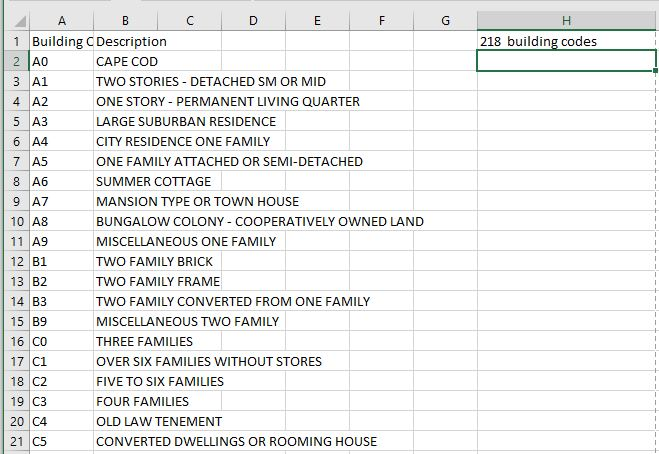


### Bronx: 

In [471]:
bronx_merged['Building Class At Time Of Sale'].value_counts()

B1    1259
D4    1242
C0    1016
B2     701
A1     694
      ... 
W4       1
D8       1
I6       1
H4       1
N2       1
Name: Building Class At Time Of Sale, Length: 114, dtype: int64

In [472]:
pattern = r'[A]'
bronx_a= bronx_merged.loc[bronx_merged['Building Class At Time Of Sale'].str.contains(pattern)]


In [473]:
patternb = r'[B]'
bronx_b= bronx_merged.loc[bronx_merged['Building Class At Time Of Sale'].str.contains(patternb)]


In [474]:
patternr = r'[R][1-4]'
bronx_r= bronx_merged.loc[bronx_merged['Building Class At Time Of Sale'].str.contains(patternr)]


### Observation: 

Only caputuring residential homes and not commercial properties this will reduce the dataset from 10,114 to 5,004 rows. Within the properties also includes many sales price with a 0 or 10 dollars. Most likely these are deed/title transfers. We will replace the 0 and 10 values with the mean price.  

In [475]:
bronx_merged = pd.concat([bronx_a, bronx_b, bronx_r], ignore_index=True)
bronx_merged.shape

(5004, 21)

In [476]:
bronx_avg = bronx_merged[bronx_merged['Sale Price'] > 10000]
bronx_mean = bronx_avg['Sale Price'].agg(numpy.mean)
final_mean = round(bronx_mean)

bronx_merged['Sale Price'] = bronx_merged['Sale Price'].mask(bronx_merged['Sale Price'] <= 10000, final_mean)

In [477]:
bronx_merged['Neighborhood'] = bronx_merged['Neighborhood'].str.strip()
bronx_merged['Neighborhood'].unique()

array(['BATHGATE', 'BAYCHESTER', 'BEDFORD PARK/NORWOOD', 'BELMONT',
       'BRONXDALE', 'CASTLE HILL/UNIONPORT', 'CITY ISLAND',
       'CITY ISLAND-PELHAM STRIP', 'CO-OP CITY', 'COUNTRY CLUB',
       'CROTONA PARK', 'EAST TREMONT', 'FIELDSTON',
       'HIGHBRIDGE/MORRIS HEIGHTS', 'KINGSBRIDGE HTS/UNIV HTS',
       'KINGSBRIDGE/JEROME PARK', 'MORRIS PARK/VAN NEST',
       'MORRISANIA/LONGWOOD', 'MOTT HAVEN/PORT MORRIS',
       'MOUNT HOPE/MOUNT EDEN', 'PARKCHESTER', 'PELHAM GARDENS',
       'PELHAM PARKWAY NORTH', 'PELHAM PARKWAY SOUTH', 'RIVERDALE',
       'SCHUYLERVILLE/PELHAM BAY', 'SOUNDVIEW', 'THROGS NECK',
       'WAKEFIELD', 'WESTCHESTER', 'WILLIAMSBRIDGE', 'WOODLAWN',
       'MELROSE/CONCOURSE', 'BRONX PARK', 'FORDHAM', 'HUNTS POINT'],
      dtype=object)

In [478]:
grouped = bronx_merged.groupby('Neighborhood')
sales_grouped= grouped['Sale Price']
bronx_mean = round(sales_grouped.mean())

print(bronx_mean.sort_values())
print(bronx_mean.describe())

Neighborhood
PARKCHESTER                  185181.0
CO-OP CITY                   246064.0
MOUNT HOPE/MOUNT EDEN        251667.0
EAST TREMONT                 295163.0
HUNTS POINT                  296069.0
MORRISANIA/LONGWOOD          302550.0
MOTT HAVEN/PORT MORRIS       302803.0
MELROSE/CONCOURSE            310944.0
BELMONT                      312131.0
KINGSBRIDGE HTS/UNIV HTS     312631.0
WILLIAMSBRIDGE               320674.0
BRONXDALE                    320749.0
BATHGATE                     322344.0
CROTONA PARK                 323034.0
BAYCHESTER                   331476.0
HIGHBRIDGE/MORRIS HEIGHTS    333410.0
FORDHAM                      334835.0
WAKEFIELD                    337214.0
WESTCHESTER                  340239.0
SOUNDVIEW                    345273.0
CASTLE HILL/UNIONPORT        350851.0
THROGS NECK                  357791.0
SCHUYLERVILLE/PELHAM BAY     359034.0
BEDFORD PARK/NORWOOD         362105.0
COUNTRY CLUB                 371564.0
WOODLAWN                     373900.0

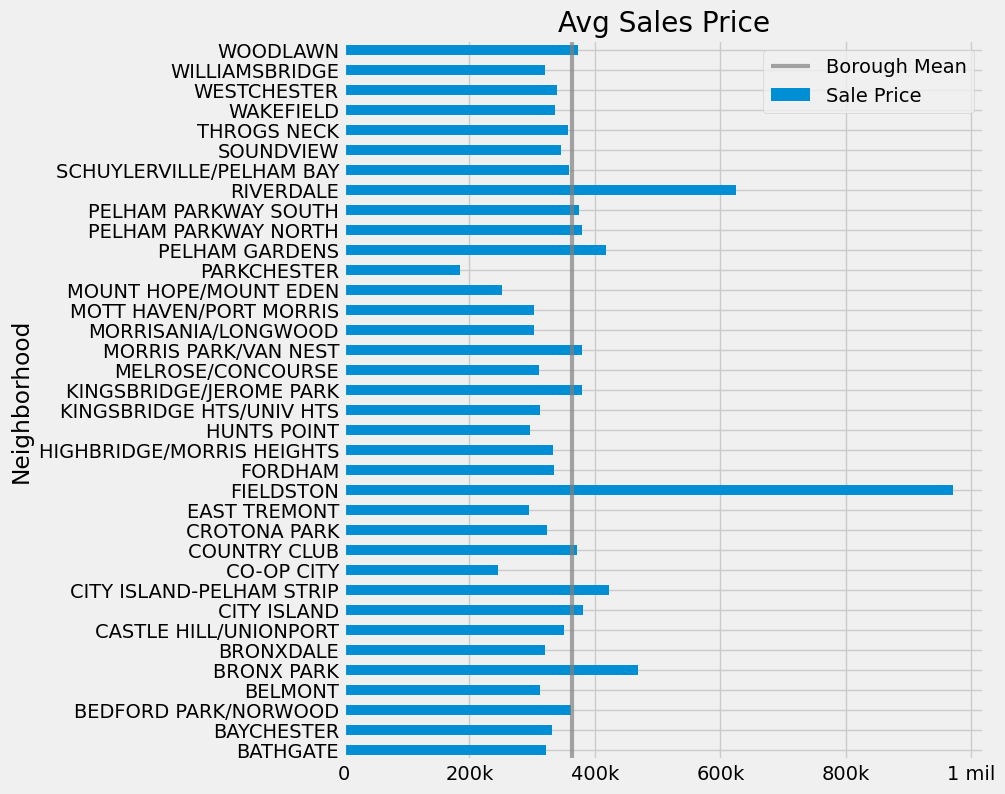

In [516]:
fig = plt.figure()
ax = fig.add_axes([0.2, 0.2, 1.0, 1.5])
ax.set_xticklabels(['0','200k','400k','600k','800k','1 mil'])
ax.set_title('Avg Sales Price')
plt.axvline(x= 363900, c='grey', linewidth= 3, alpha=0.7, label='Borough Mean')
bronx_mean.plot.barh()
plt.legend()
plt.show()

### Observation: 

As we can see most of the neighborhoods in the Bronx fall between the 300-400k range for sales price. Lets find the top rated schools in the bronx. 

### Exploring Queens: 

In [480]:
queens_11=data['2011_Queens']
queens_12=data['2012_Queens']

queens_merged = pd.concat([queens_12,queens_11], ignore_index = True)

pattern = r'[A]'
queens_a= queens_merged.loc[queens_merged['Building Class At Time Of Sale'].str.contains(pattern)]

patternb = r'[B]'
queens_b= queens_merged.loc[queens_merged['Building Class At Time Of Sale'].str.contains(patternb)]

patternr = r'[R][1-4]'
queens_r= queens_merged.loc[queens_merged['Building Class At Time Of Sale'].str.contains(patternr)]

queens_merged = pd.concat([queens_a, queens_b, queens_r], ignore_index=True)
print(queens_merged.shape)

queens_avg = queens_merged[queens_merged['Sale Price'] > 10000]
queens_mean = queens_avg['Sale Price'].agg(numpy.mean)
final_mean = round(queens_mean)
print(final_mean)

queens_merged['Sale Price'] = queens_merged['Sale Price'].mask(queens_merged['Sale Price'] <= 10000, final_mean)

(27948, 21)
458627


In [481]:
queens_merged['Neighborhood'] = queens_merged['Neighborhood'].str.strip()
queens_merged['Neighborhood'].unique()

array(['AIRPORT LA GUARDIA', 'ARVERNE', 'ASTORIA', 'BAYSIDE',
       'BEECHHURST', 'BELLE HARBOR', 'BELLEROSE', 'BRIARWOOD',
       'BROAD CHANNEL', 'CAMBRIA HEIGHTS', 'COLLEGE POINT', 'CORONA',
       'DOUGLASTON', 'EAST ELMHURST', 'ELMHURST', 'FAR ROCKAWAY',
       'FLORAL PARK', 'FLUSHING-NORTH', 'FLUSHING-SOUTH', 'FOREST HILLS',
       'FRESH MEADOWS', 'GLEN OAKS', 'GLENDALE', 'HAMMELS', 'HILLCREST',
       'HOLLIS', 'HOLLIS HILLS', 'HOLLISWOOD', 'HOWARD BEACH',
       'JACKSON HEIGHTS', 'JAMAICA', 'JAMAICA BAY', 'JAMAICA ESTATES',
       'JAMAICA HILLS', 'KEW GARDENS', 'LAURELTON', 'LITTLE NECK',
       'LONG ISLAND CITY', 'MASPETH', 'MIDDLE VILLAGE', 'NEPONSIT',
       'OAKLAND GARDENS', 'OZONE PARK', 'QUEENS VILLAGE', 'REGO PARK',
       'RICHMOND HILL', 'RIDGEWOOD', 'ROCKAWAY PARK', 'ROSEDALE',
       'SO. JAMAICA-BAISLEY PARK', 'SOUTH JAMAICA', 'SOUTH OZONE PARK',
       'SPRINGFIELD GARDENS', 'ST. ALBANS', 'SUNNYSIDE', 'WHITESTONE',
       'WOODHAVEN', 'WOODSIDE', 'QUEENS-UNK

In [482]:
#neighborhood listed as queens-unknown

queens_merged[queens_merged['Neighborhood'] == 'QUEENS-UNKNOWN']

,Borough,Neighborhood,Building Class Category,Tax Class At Present,Block,Lot,Ease-Ment,Building Class At Present,Address,Apartment Number,Zip Code,Residential Units,Commercial Units,Total Units,Land Square Feet,Gross Square Feet,Year Built,Tax Class At Time Of Sale,Building Class At Time Of Sale,Sale Price,Sale Date
21468,4,QUEENS-UNKNOWN,02 TWO FAMILY HOMES,1,9625,75,,B1,87-35 VAN WYCK EXPRESSWAY,,11435,2,0,2,3800,2112,1930,1,B1,620000,2011-03-31 00:00:00


### Notes: 

After completing a google search this address is actually located in the Jamaica neighborhood. So I will replace the neighborhood name with Jamaica. 
The Airport La Guardia has actual homes so this will remain unchanged. 

In [483]:
queens_merged['Neighborhood'] = queens_merged['Neighborhood'].replace('QUEENS-UNKNOWN','JAMAICA')
queens_merged['Neighborhood'].unique()

array(['AIRPORT LA GUARDIA', 'ARVERNE', 'ASTORIA', 'BAYSIDE',
       'BEECHHURST', 'BELLE HARBOR', 'BELLEROSE', 'BRIARWOOD',
       'BROAD CHANNEL', 'CAMBRIA HEIGHTS', 'COLLEGE POINT', 'CORONA',
       'DOUGLASTON', 'EAST ELMHURST', 'ELMHURST', 'FAR ROCKAWAY',
       'FLORAL PARK', 'FLUSHING-NORTH', 'FLUSHING-SOUTH', 'FOREST HILLS',
       'FRESH MEADOWS', 'GLEN OAKS', 'GLENDALE', 'HAMMELS', 'HILLCREST',
       'HOLLIS', 'HOLLIS HILLS', 'HOLLISWOOD', 'HOWARD BEACH',
       'JACKSON HEIGHTS', 'JAMAICA', 'JAMAICA BAY', 'JAMAICA ESTATES',
       'JAMAICA HILLS', 'KEW GARDENS', 'LAURELTON', 'LITTLE NECK',
       'LONG ISLAND CITY', 'MASPETH', 'MIDDLE VILLAGE', 'NEPONSIT',
       'OAKLAND GARDENS', 'OZONE PARK', 'QUEENS VILLAGE', 'REGO PARK',
       'RICHMOND HILL', 'RIDGEWOOD', 'ROCKAWAY PARK', 'ROSEDALE',
       'SO. JAMAICA-BAISLEY PARK', 'SOUTH JAMAICA', 'SOUTH OZONE PARK',
       'SPRINGFIELD GARDENS', 'ST. ALBANS', 'SUNNYSIDE', 'WHITESTONE',
       'WOODHAVEN', 'WOODSIDE', 'FLUSHING M

In [484]:
grouped = queens_merged.groupby('Neighborhood')
sales_grouped= grouped['Sale Price']
queens_mean = round(sales_grouped.mean())


In [485]:
queens_mean.describe()

count        59.000000
mean     466233.254237
std       94083.475658
min      323513.000000
25%      390490.000000
50%      448440.000000
75%      499505.500000
max      793307.000000
Name: Sale Price, dtype: float64

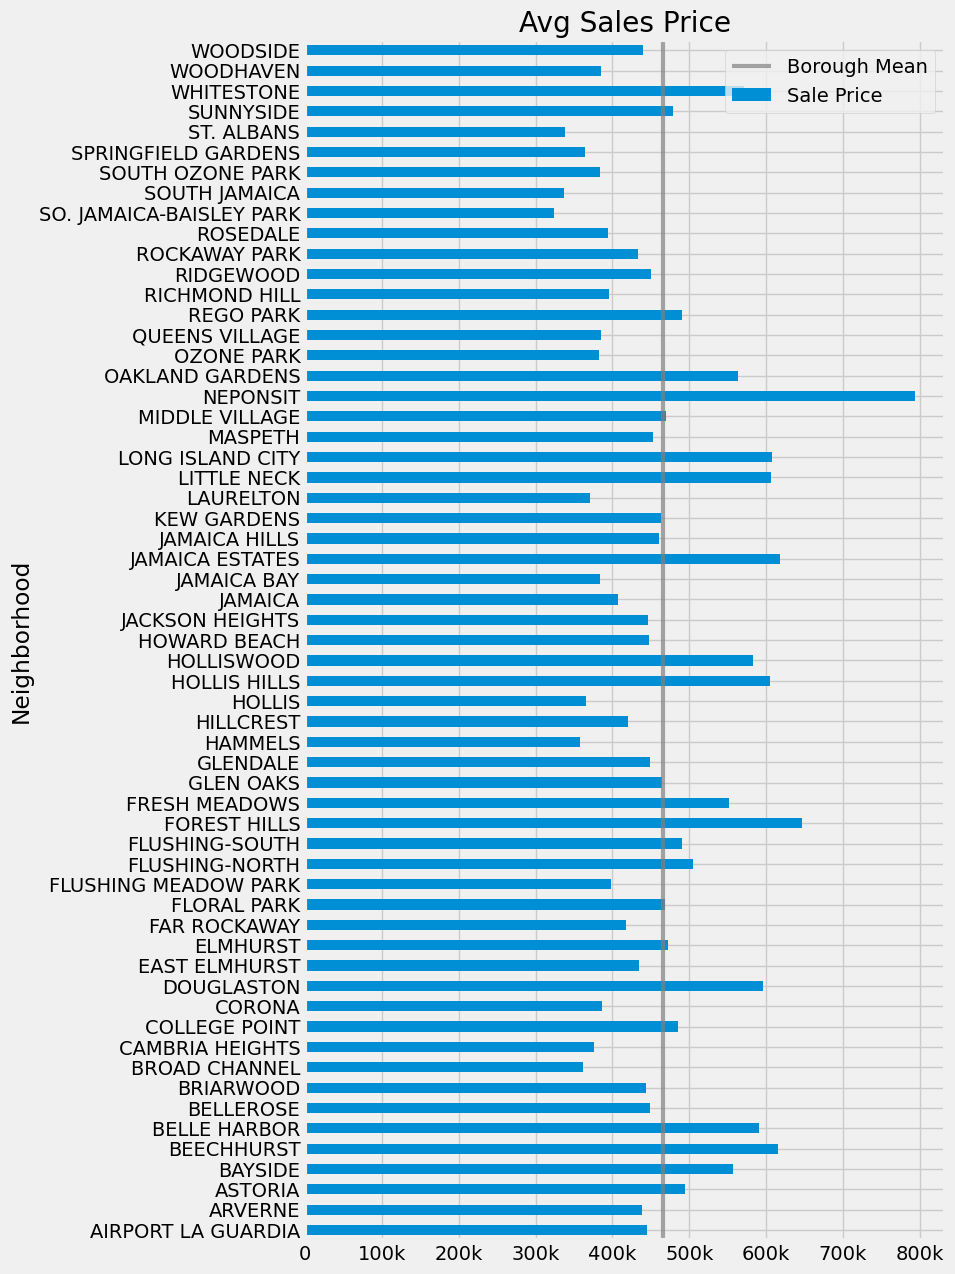

In [515]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 1.0, 2.5])
ax.set_title('Avg Sales Price')
ax.set_xticklabels(['0','100k','200k','300k','400k','500k', '600k', '700k','800k'])
plt.axvline(x= 466000, c='grey', linewidth= 3, alpha=0.7, label='Borough Mean')
queens_mean.plot.barh()
plt.legend()
plt.show()

### Exploring Brooklyn: 

In [487]:
brooklyn_11=data['2011_Brooklyn']
brooklyn_12=data['2012_Brooklyn']

brooklyn_merged = pd.concat([brooklyn_12,brooklyn_11], ignore_index = True)

pattern = r'[A]'
brooklyn_a= brooklyn_merged.loc[brooklyn_merged['Building Class At Time Of Sale'].str.contains(pattern)]

patternb = r'[B]'
brooklyn_b= brooklyn_merged.loc[brooklyn_merged['Building Class At Time Of Sale'].str.contains(patternb)]

patternr = r'[R][1-4]'
brooklyn_r= brooklyn_merged.loc[brooklyn_merged['Building Class At Time Of Sale'].str.contains(patternr)]

brooklyn_merged = pd.concat([brooklyn_a, brooklyn_b, brooklyn_r], ignore_index=True)
print(brooklyn_merged.shape)

brooklyn_avg = brooklyn_merged[brooklyn_merged['Sale Price'] > 10000]
brooklyn_mean = brooklyn_avg['Sale Price'].agg(numpy.mean)
final_meanb = round(brooklyn_mean)
print(final_meanb)

brooklyn_merged['Sale Price'] = brooklyn_merged['Sale Price'].mask(brooklyn_merged['Sale Price'] <= 10000, final_meanb)

(23934, 21)
620069


In [488]:
brooklyn_merged['Neighborhood'] = brooklyn_merged['Neighborhood'].str.strip()
brooklyn_merged['Neighborhood'].unique()

array(['BATH BEACH', 'BAY RIDGE', 'BEDFORD STUYVESANT', 'BENSONHURST',
       'BERGEN BEACH', 'BOERUM HILL', 'BOROUGH PARK', 'BRIGHTON BEACH',
       'BROOKLYN HEIGHTS', 'BROWNSVILLE', 'BUSHWICK', 'CANARSIE',
       'CARROLL GARDENS', 'CLINTON HILL', 'COBBLE HILL',
       'COBBLE HILL-WEST', 'CONEY ISLAND', 'CROWN HEIGHTS',
       'CYPRESS HILLS', 'DOWNTOWN-FULTON MALL', 'DYKER HEIGHTS',
       'EAST NEW YORK', 'FLATBUSH-CENTRAL', 'FLATBUSH-EAST',
       'FLATBUSH-LEFFERTS GARDEN', 'FLATBUSH-NORTH', 'FLATLANDS',
       'FORT GREENE', 'GERRITSEN BEACH', 'GOWANUS', 'GRAVESEND',
       'GREENPOINT', 'KENSINGTON', 'MADISON', 'MANHATTAN BEACH',
       'MARINE PARK', 'MIDWOOD', 'MILL BASIN', 'NAVY YARD', 'OCEAN HILL',
       'OCEAN PARKWAY-NORTH', 'OCEAN PARKWAY-SOUTH', 'OLD MILL BASIN',
       'PARK SLOPE', 'PARK SLOPE SOUTH', 'PROSPECT HEIGHTS', 'RED HOOK',
       'SEAGATE', 'SHEEPSHEAD BAY', 'SUNSET PARK', 'WILLIAMSBURG-EAST',
       'WILLIAMSBURG-NORTH', 'WILLIAMSBURG-SOUTH', 'WINDSOR TE

In [489]:
brooklyn_merged[brooklyn_merged['Neighborhood'] == 'BROOKLYN-UNKNOWN']

,Borough,Neighborhood,Building Class Category,Tax Class At Present,Block,Lot,Ease-Ment,Building Class At Present,Address,Apartment Number,Zip Code,Residential Units,Commercial Units,Total Units,Land Square Feet,Gross Square Feet,Year Built,Tax Class At Time Of Sale,Building Class At Time Of Sale,Sale Price,Sale Date
6236,3,BROOKLYN-UNKNOWN,02 TWO FAMILY HOMES,1,1331,47,,B9,479A EAST NEW YORK AVENUE,,11225,2,0,2,1800,1500,1930,1,B9,620069,2012-07-01 00:00:00
20097,3,BROOKLYN-UNKNOWN,12 CONDOS - WALKUP APARTMENTS,2,3290,1102,,R2,408 HARMAN STREET,2,11237,1,0,1,0,0,0,2,R2,304200,2011-01-27 00:00:00
20098,3,BROOKLYN-UNKNOWN,12 CONDOS - WALKUP APARTMENTS,2,3290,1103,,R2,408 HARMAN STREET,3,11237,1,0,1,0,0,0,2,R2,296088,2011-04-15 00:00:00
20099,3,BROOKLYN-UNKNOWN,12 CONDOS - WALKUP APARTMENTS,2,3290,1202,,R2,1427 GREENE AVENUE,2,11237,1,0,1,0,0,0,2,R2,268710,2011-03-17 00:00:00
20100,3,BROOKLYN-UNKNOWN,12 CONDOS - WALKUP APARTMENTS,2,3290,1303,,R2,1425 GREENE AVENUE,3,11237,1,0,1,0,0,0,2,R2,261664,2011-03-28 00:00:00
20101,3,BROOKLYN-UNKNOWN,13 CONDOS - ELEVATOR APARTMENTS,2,299,1056,,R4,86 CONGRESS STREET,507,11201,1,0,1,0,0,2009,2,R4,620069,2011-04-27 00:00:00


### Notes: 

I will reassign these properties to the correct neighborhoods by using google search.  

* 479A EAST NEW YORK AVENUE === FLATBUSH-LEFFERTS GARDEN,

* 408 HARMAN STREET === BUSHWICK, 

* 1425-1427 GREENE AVENUE === BUSHWICK,

* 86 CONGRESS STREET === COBBLE HILL 


In [490]:
brooklyn_merged.loc[6236] = brooklyn_merged.loc[6236].replace('BROOKLYN-UNKNOWN','FLATBUSH-LEFFERTS GARDEN')
brooklyn_merged.loc[20097]= brooklyn_merged.loc[20097].replace('BROOKLYN-UNKNOWN','BUSHWICK')
brooklyn_merged.loc[20098]=brooklyn_merged.loc[20098].replace('BROOKLYN-UNKNOWN','BUSHWICK')
brooklyn_merged.loc[20099]=brooklyn_merged.loc[20099].replace('BROOKLYN-UNKNOWN','BUSHWICK')
brooklyn_merged.loc[20100]=brooklyn_merged.loc[20100].replace('BROOKLYN-UNKNOWN','BUSHWICK')
brooklyn_merged.loc[20101]=brooklyn_merged.loc[20101].replace('BROOKLYN-UNKNOWN','COBBLE HILL')

brooklyn_merged['Neighborhood'].unique()

array(['BATH BEACH', 'BAY RIDGE', 'BEDFORD STUYVESANT', 'BENSONHURST',
       'BERGEN BEACH', 'BOERUM HILL', 'BOROUGH PARK', 'BRIGHTON BEACH',
       'BROOKLYN HEIGHTS', 'BROWNSVILLE', 'BUSHWICK', 'CANARSIE',
       'CARROLL GARDENS', 'CLINTON HILL', 'COBBLE HILL',
       'COBBLE HILL-WEST', 'CONEY ISLAND', 'CROWN HEIGHTS',
       'CYPRESS HILLS', 'DOWNTOWN-FULTON MALL', 'DYKER HEIGHTS',
       'EAST NEW YORK', 'FLATBUSH-CENTRAL', 'FLATBUSH-EAST',
       'FLATBUSH-LEFFERTS GARDEN', 'FLATBUSH-NORTH', 'FLATLANDS',
       'FORT GREENE', 'GERRITSEN BEACH', 'GOWANUS', 'GRAVESEND',
       'GREENPOINT', 'KENSINGTON', 'MADISON', 'MANHATTAN BEACH',
       'MARINE PARK', 'MIDWOOD', 'MILL BASIN', 'NAVY YARD', 'OCEAN HILL',
       'OCEAN PARKWAY-NORTH', 'OCEAN PARKWAY-SOUTH', 'OLD MILL BASIN',
       'PARK SLOPE', 'PARK SLOPE SOUTH', 'PROSPECT HEIGHTS', 'RED HOOK',
       'SEAGATE', 'SHEEPSHEAD BAY', 'SUNSET PARK', 'WILLIAMSBURG-EAST',
       'WILLIAMSBURG-NORTH', 'WILLIAMSBURG-SOUTH', 'WINDSOR TE

In [491]:
grouped = brooklyn_merged.groupby('Neighborhood')
sales_grouped= grouped['Sale Price']
brooklyn_mean = round(sales_grouped.mean())

print(brooklyn_mean.describe())

count    6.000000e+01
mean     6.516586e+05
std      2.097088e+05
min      3.793970e+05
25%      4.998088e+05
50%      6.008625e+05
75%      7.477198e+05
max      1.530797e+06
Name: Sale Price, dtype: float64


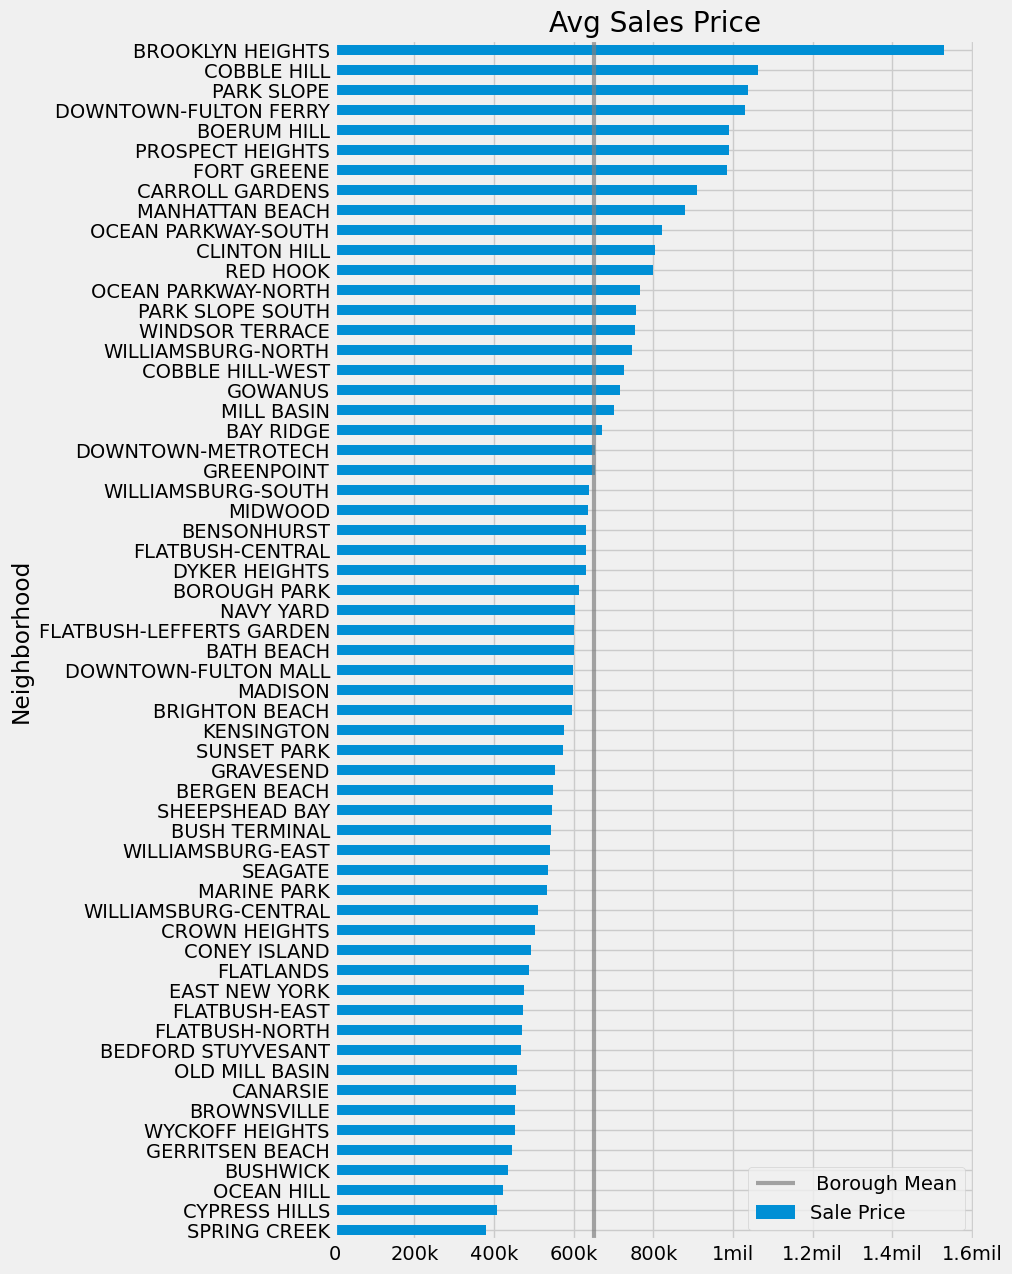

In [514]:
fig = plt.figure()
ax = fig.add_axes([0.2, 0.2, 1.0, 2.5])
ax.set_title('Avg Sales Price')
ax.set_xticklabels(['0','200k','400k','600k','800k','1mil','1.2mil','1.4mil','1.6mil' ])
plt.axvline(x= 650000, c='grey', linewidth= 3, alpha=0.7, label=' Borough Mean')
brooklyn_mean.sort_values().plot.barh()
plt.legend()
plt.show()

### Exploring Staten Island: 

In [493]:
staten_11=data['2011_StatenIsland'] 
staten_12=data['2012_StatenIsland']

staten_merged = pd.concat([staten_12,staten_11], ignore_index = True)

pattern = r'[A]'
staten_a= staten_merged.loc[staten_merged['Building Class At Time Of Sale'].str.contains(pattern)]

patternb = r'[B]'
staten_b= staten_merged.loc[staten_merged['Building Class At Time Of Sale'].str.contains(patternb)]

patternr = r'[R][1-4]'
staten_r= staten_merged.loc[staten_merged['Building Class At Time Of Sale'].str.contains(patternr)]

staten_merged = pd.concat([staten_a, staten_b, staten_r], ignore_index=True)
print(staten_merged.shape)

staten_avg = staten_merged[staten_merged['Sale Price'] > 10000]
staten_mean = staten_avg['Sale Price'].agg(numpy.mean)
final_means = round(staten_mean)
print(final_means)

staten_merged['Sale Price'] = staten_merged['Sale Price'].mask(staten_merged['Sale Price'] <= 10000, final_means)

(9343, 21)
417508


In [494]:
staten_merged['Neighborhood'] = staten_merged['Neighborhood'].str.strip()
staten_merged['Neighborhood'].unique()

array(['ANNADALE', 'ARDEN HEIGHTS', 'ARROCHAR', 'ARROCHAR-SHORE ACRES',
       'BULLS HEAD', 'CASTLETON CORNERS', 'CLOVE LAKES', 'CONCORD',
       'CONCORD-FOX HILLS', 'DONGAN HILLS', 'DONGAN HILLS-COLONY',
       'DONGAN HILLS-OLD TOWN', 'ELTINGVILLE', 'EMERSON HILL',
       'GRANT CITY', 'GRASMERE', 'GREAT KILLS', 'GREAT KILLS-BAY TERRACE',
       'GRYMES HILL', 'HUGUENOT', 'LIVINGSTON', 'MANOR HEIGHTS',
       'MARINERS HARBOR', 'MIDLAND BEACH', 'NEW BRIGHTON', 'NEW DORP',
       'NEW DORP-BEACH', 'NEW DORP-HEIGHTS', 'NEW SPRINGVILLE', 'OAKWOOD',
       'OAKWOOD-BEACH', 'PLEASANT PLAINS', 'PORT IVORY', 'PORT RICHMOND',
       'PRINCES BAY', 'RICHMONDTOWN', 'RICHMONDTOWN-LIGHTHS HILL',
       'ROSEBANK', 'ROSSVILLE', 'ROSSVILLE-CHARLESTON',
       'ROSSVILLE-RICHMOND VALLEY', 'SILVER LAKE', 'SOUTH BEACH',
       'STAPLETON', 'STAPLETON-CLIFTON', 'STATEN ISLAND-UNKNOWN',
       'SUNNYSIDE', 'TODT HILL', 'TOMPKINSVILLE', 'TOTTENVILLE', 'TRAVIS',
       'WEST NEW BRIGHTON', 'WESTERLEIGH

In [495]:
staten_merged[staten_merged['Neighborhood'] == 'STATEN ISLAND-UNKNOWN']

,Borough,Neighborhood,Building Class Category,Tax Class As Of Final Roll 18/1,Block,Lot,Ease-Ment,Building Class As Of Final Roll 18/1,Address,Apartment Number,Zip Code,Residential Units,Commercial Units,Total Units,Land Square Feet,Gross Square Feet,Year Built,Tax Class At Time Of Sale,Building Class At Time Of Sale,Sale Price,Sale Date
2776,5,STATEN ISLAND-UNKNOWN,01 ONE FAMILY HOMES,1,5026,21,,B9,147 JUSTIN AVENUE,,10306,2,0,2,21250,2430,1930,1,A1,1240000,2012-01-26 00:00:00
5554,5,STATEN ISLAND-UNKNOWN,01 ONE FAMILY HOMES,1,7105,1,,A1,639 TURNER STREET,,10309,1,0,1,42373,1962,2010,1,A1,501930,2011-07-15 00:00:00
5555,5,STATEN ISLAND-UNKNOWN,01 ONE FAMILY HOMES,1,7105,1,,A1,104 TURNER STREET,,10309,1,0,1,42373,1962,2010,1,A1,465426,2011-06-22 00:00:00
5556,5,STATEN ISLAND-UNKNOWN,01 ONE FAMILY HOMES,1,7105,1,,A1,639 TURNER STREET,,10309,1,0,1,42373,1962,2010,1,A1,417508,2011-05-05 00:00:00
5557,5,STATEN ISLAND-UNKNOWN,01 ONE FAMILY HOMES,1,7105,1,,A1,1661 WOODROW ROAD,,10309,1,0,1,42373,1962,2010,1,A1,417508,2011-02-14 00:00:00
8314,5,STATEN ISLAND-UNKNOWN,02 TWO FAMILY HOMES,1,7022,7,,B2,24 BROOKSIDE LOOP,,10309,2,0,2,5848,3355,2011,1,B2,783034,2011-09-06 00:00:00
8315,5,STATEN ISLAND-UNKNOWN,02 TWO FAMILY HOMES,1,7022,8,,B2,26 BROOKSIDE LOOP,,10309,2,0,2,5769,3603,2011,1,B2,787106,2011-11-09 00:00:00
8316,5,STATEN ISLAND-UNKNOWN,02 TWO FAMILY HOMES,1,7022,17,,B2,38 BROOKSIDE LOOP,,10309,2,0,2,6171,3985,2011,1,B2,850000,2011-12-28 00:00:00
8317,5,STATEN ISLAND-UNKNOWN,02 TWO FAMILY HOMES,1,7022,19,,B2,40 BROOKSIDE LOOP,,10309,2,0,2,4815,3731,2011,1,B2,783034,2011-11-29 00:00:00
8318,5,STATEN ISLAND-UNKNOWN,02 TWO FAMILY HOMES,1,7022,63,,B2,29 BROOKSIDE LOOP,,10309,2,0,2,5139,3732,2011,1,B2,783034,2011-09-01 00:00:00


#### Notes:

I will reassign these properties to the correct neighborhoods by using google search.  

* 147 JUSTIN AVENUE IS LOCATED IN BAY TERRACE  

* 639 TURNER STREET, 104 TURNER STREET IS LOCATED IN CHARLESTON  

* 1661 WOODROW ROAD	IS LOCATED IN CHARLESTON  

* BROOKSIDE LOOP IS LOCATED IN WOODROW 

In [496]:
staten_merged.loc[2776]=staten_merged.loc[2776].replace('BAY TERRACE','GREAT KILLS-BAY TERRACE')
staten_merged.loc[5554]=staten_merged.loc[5554].replace('STATEN ISLAND-UNKNOWN','CHARLESTON')
staten_merged.loc[5555]=staten_merged.loc[5555].replace('STATEN ISLAND-UNKNOWN','CHARLESTON')
staten_merged.loc[5556]=staten_merged.loc[5556].replace('STATEN ISLAND-UNKNOWN','CHARLESTON')
staten_merged.loc[5557]=staten_merged.loc[5557].replace('STATEN ISLAND-UNKNOWN','CHARLESTON')
staten_merged['Neighborhood'] = staten_merged['Neighborhood'].replace('STATEN ISLAND-UNKNOWN','WOODROW')
staten_merged['Neighborhood'].unique()

array(['ANNADALE', 'ARDEN HEIGHTS', 'ARROCHAR', 'ARROCHAR-SHORE ACRES',
       'BULLS HEAD', 'CASTLETON CORNERS', 'CLOVE LAKES', 'CONCORD',
       'CONCORD-FOX HILLS', 'DONGAN HILLS', 'DONGAN HILLS-COLONY',
       'DONGAN HILLS-OLD TOWN', 'ELTINGVILLE', 'EMERSON HILL',
       'GRANT CITY', 'GRASMERE', 'GREAT KILLS', 'GREAT KILLS-BAY TERRACE',
       'GRYMES HILL', 'HUGUENOT', 'LIVINGSTON', 'MANOR HEIGHTS',
       'MARINERS HARBOR', 'MIDLAND BEACH', 'NEW BRIGHTON', 'NEW DORP',
       'NEW DORP-BEACH', 'NEW DORP-HEIGHTS', 'NEW SPRINGVILLE', 'OAKWOOD',
       'OAKWOOD-BEACH', 'PLEASANT PLAINS', 'PORT IVORY', 'PORT RICHMOND',
       'PRINCES BAY', 'RICHMONDTOWN', 'RICHMONDTOWN-LIGHTHS HILL',
       'ROSEBANK', 'ROSSVILLE', 'ROSSVILLE-CHARLESTON',
       'ROSSVILLE-RICHMOND VALLEY', 'SILVER LAKE', 'SOUTH BEACH',
       'STAPLETON', 'STAPLETON-CLIFTON', 'WOODROW', 'SUNNYSIDE',
       'TODT HILL', 'TOMPKINSVILLE', 'TOTTENVILLE', 'TRAVIS',
       'WEST NEW BRIGHTON', 'WESTERLEIGH', 'WILLOWBROO

In [497]:
grouped = staten_merged.groupby('Neighborhood')
sales_grouped= grouped['Sale Price']
staten_mean = round(sales_grouped.mean())

print(staten_mean.describe())

count        56.000000
mean     429905.339286
std      105267.430363
min      307056.000000
25%      368467.250000
50%      411391.000000
75%      453481.500000
max      878067.000000
Name: Sale Price, dtype: float64


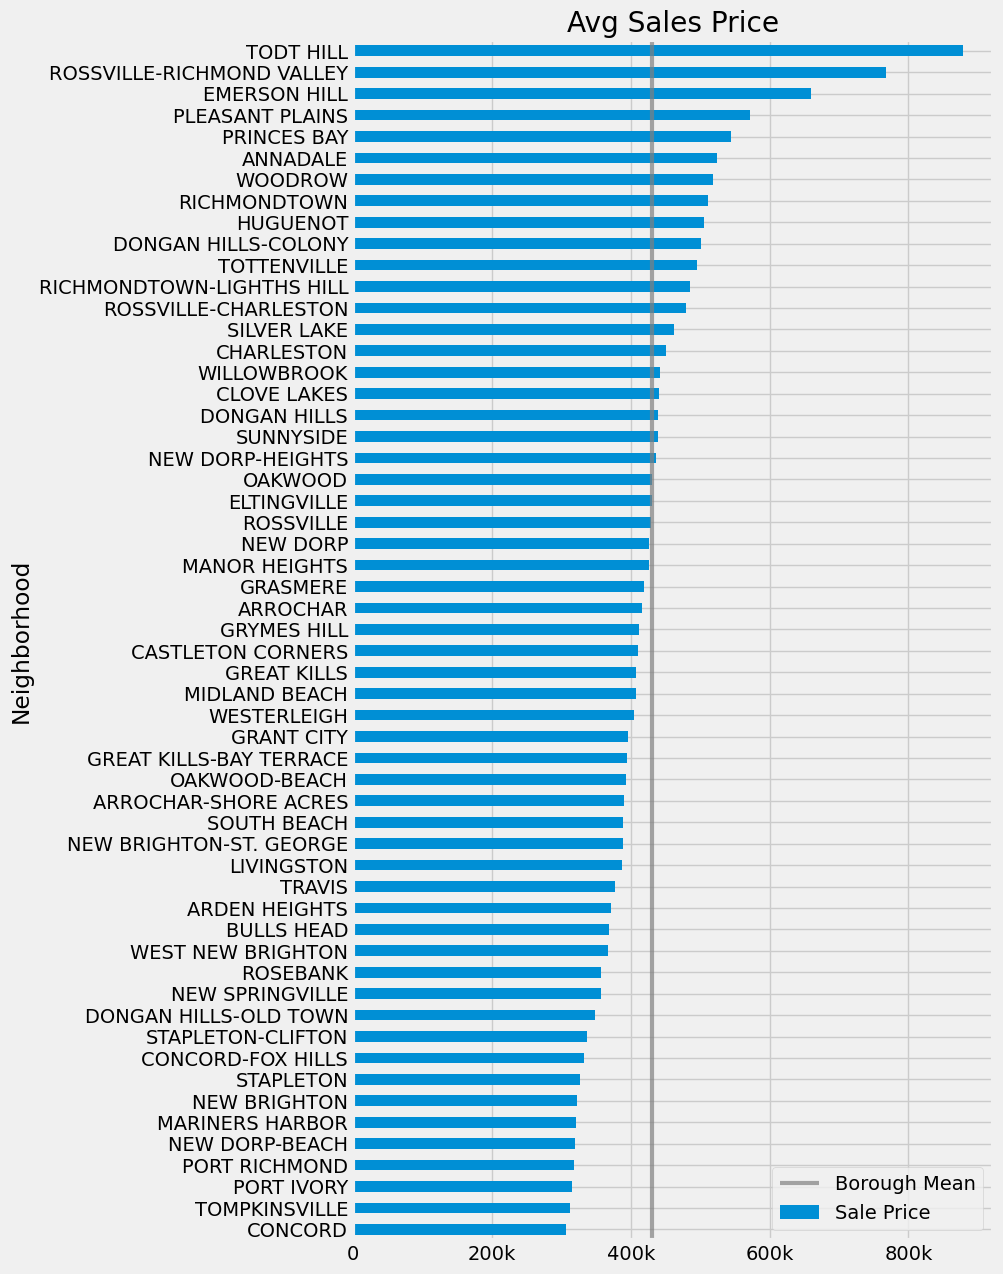

In [513]:
fig = plt.figure()
ax = fig.add_axes([0.2, 0.2, 1.0, 2.5])
ax.set_title('Avg Sales Price')
ax.set_xticklabels(['0','200k','400k','600k','800k'])
plt.axvline(x= 430000, c='grey', linewidth= 3, alpha=0.7, label='Borough Mean')
staten_mean.sort_values().plot.barh()
plt.legend()
plt.show()

### Exploring Manhattan: 

In [499]:
manhattan_11=data['2011_Manhattan'] 
manhattan_12=data['2012_Manhattan']

manhattan_merged = pd.concat([manhattan_12,manhattan_11], ignore_index = True)

pattern = r'[A]'
manhattan_a= manhattan_merged.loc[manhattan_merged['Building Class At Time Of Sale'].str.contains(pattern)]

patternb = r'[B]'
manhattan_b= manhattan_merged.loc[manhattan_merged['Building Class At Time Of Sale'].str.contains(patternb)]

patternr = r'[R][1-4]'
manhattan_r= manhattan_merged.loc[manhattan_merged['Building Class At Time Of Sale'].str.contains(patternr)]

manhattan_merged = pd.concat([manhattan_a, manhattan_b, manhattan_r], ignore_index=True)
print(manhattan_merged.shape)

manhattan_avg = manhattan_merged[manhattan_merged['Sale Price'] > 10000]
manhattan_mean = manhattan_avg['Sale Price'].agg(numpy.mean)
final_meanm = round(manhattan_mean)
print(final_meanm)

manhattan_merged['Sale Price'] = manhattan_merged['Sale Price'].mask(manhattan_merged['Sale Price'] <= 10000, final_meanm)

(16955, 21)
1858307


In [500]:
manhattan_merged['Neighborhood'] = manhattan_merged['Neighborhood'].str.strip()
manhattan_merged['Neighborhood'].unique()

array(['CHELSEA', 'EAST VILLAGE', 'FASHION', 'GRAMERCY',
       'GREENWICH VILLAGE-CENTRAL', 'GREENWICH VILLAGE-WEST',
       'HARLEM-CENTRAL', 'HARLEM-EAST', 'HARLEM-UPPER', 'INWOOD',
       'LITTLE ITALY', 'MANHATTAN VALLEY', 'MANHATTAN-UNKNOWN',
       'MIDTOWN EAST', 'MURRAY HILL', 'SOHO', 'TRIBECA',
       'UPPER EAST SIDE (59-79)', 'UPPER EAST SIDE (79-96)',
       'UPPER WEST SIDE (59-79)', 'UPPER WEST SIDE (79-96)',
       'UPPER WEST SIDE (96-116)', 'WASHINGTON HEIGHTS LOWER',
       'WASHINGTON HEIGHTS UPPER', 'KIPS BAY', 'CHINATOWN',
       'CIVIC CENTER', 'CLINTON', 'FINANCIAL', 'FLATIRON', 'HARLEM-WEST',
       'MIDTOWN WEST', 'SOUTHBRIDGE', 'ALPHABET CITY', 'LOWER EAST SIDE',
       'MIDTOWN CBD', 'UPPER EAST SIDE (96-110)', 'JAVITS CENTER'],
      dtype=object)

In [501]:
manhattan_merged[manhattan_merged['Neighborhood'] == 'MANHATTAN-UNKNOWN']

,Borough,Neighborhood,Building Class Category,Tax Class As Of Final Roll 18/1,Block,Lot,Ease-Ment,Building Class As Of Final Roll 18/1,Address,Apartment Number,Zip Code,Residential Units,Commercial Units,Total Units,Land Square Feet,Gross Square Feet,Year Built,Tax Class At Time Of Sale,Building Class At Time Of Sale,Sale Price,Sale Date
64,1,MANHATTAN-UNKNOWN,01 ONE FAMILY HOMES,,527,15,,,24 DOWNING STREET,,10014,0,0,0,0,0,0,1,A4,26893000,2012-02-28 00:00:00
12539,1,MANHATTAN-UNKNOWN,13 CONDOS - ELEVATOR APARTMENTS,2,16,1047,,R4,377 RECTOR PLACE,22B,10280,1,0,1,0,0,0,2,R4,1858307,2011-06-07 00:00:00
12540,1,MANHATTAN-UNKNOWN,13 CONDOS - ELEVATOR APARTMENTS,2,16,3823,,R4,2 RIVER TERRACE,25B,10280,1,0,1,0,0,2006,2,R4,1858307,2011-03-23 00:00:00


### Notes: 

I will reassign these properties to the correct neighborhoods by using google search.  

* 24 DOWNING STREET IS IN WEST VILLAGE  

* 377 RECTOR PLACE IS IN BATTERY PARK  

* 2 RIVER TERRACE IS IN BATTERY PARK 

In [502]:
manhattan_merged= manhattan_merged.drop([64])
manhattan_merged.loc[12539]=manhattan_merged.loc[12539].replace('MANHATTAN-UNKNOWN','BATTERY PARK')
manhattan_merged.loc[12540]=manhattan_merged.loc[12540].replace('MANHATTAN-UNKNOWN','BATTERY PARK')
manhattan_merged['Neighborhood'].unique()

array(['CHELSEA', 'EAST VILLAGE', 'FASHION', 'GRAMERCY',
       'GREENWICH VILLAGE-CENTRAL', 'GREENWICH VILLAGE-WEST',
       'HARLEM-CENTRAL', 'HARLEM-EAST', 'HARLEM-UPPER', 'INWOOD',
       'LITTLE ITALY', 'MANHATTAN VALLEY', 'MIDTOWN EAST', 'MURRAY HILL',
       'SOHO', 'TRIBECA', 'UPPER EAST SIDE (59-79)',
       'UPPER EAST SIDE (79-96)', 'UPPER WEST SIDE (59-79)',
       'UPPER WEST SIDE (79-96)', 'UPPER WEST SIDE (96-116)',
       'WASHINGTON HEIGHTS LOWER', 'WASHINGTON HEIGHTS UPPER', 'KIPS BAY',
       'CHINATOWN', 'CIVIC CENTER', 'CLINTON', 'FINANCIAL', 'FLATIRON',
       'HARLEM-WEST', 'MIDTOWN WEST', 'SOUTHBRIDGE', 'ALPHABET CITY',
       'LOWER EAST SIDE', 'MIDTOWN CBD', 'UPPER EAST SIDE (96-110)',
       'JAVITS CENTER', 'BATTERY PARK'], dtype=object)

In [508]:
grouped = manhattan_merged.groupby('Neighborhood')
sales_grouped= grouped['Sale Price']
manhattan_mean = round(sales_grouped.mean())

print(manhattan_mean.describe())

count    3.800000e+01
mean     1.647339e+06
std      6.514745e+05
min      5.753140e+05
25%      1.145018e+06
50%      1.528550e+06
75%      2.141834e+06
max      3.001995e+06
Name: Sale Price, dtype: float64


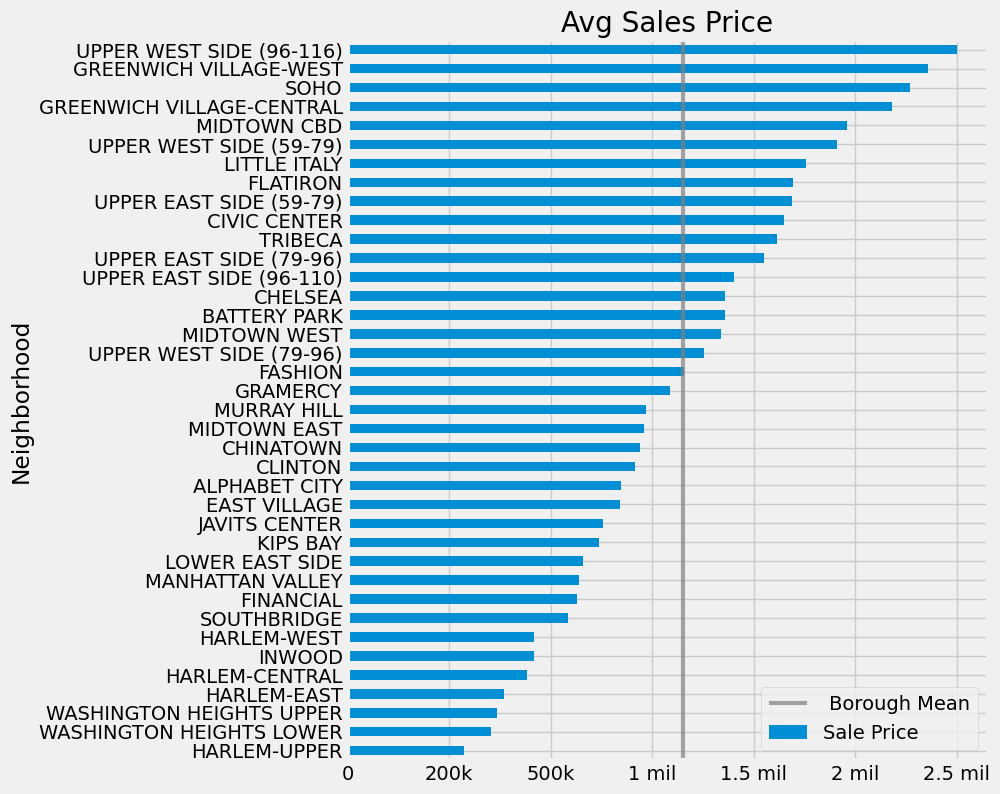

In [517]:
fig = plt.figure()
ax = fig.add_axes([0.2, 0.2, 1.0, 1.5])
ax.set_xticklabels(['0','200k','500k','1 mil','1.5 mil','2 mil','2.5 mil'])
ax.set_title('Avg Sales Price')
plt.axvline(x= 1650000, c='grey', linewidth= 3, alpha=0.7, label=' Borough Mean')
manhattan_mean.sort_values().plot.barh()
plt.legend()
plt.show()

### Using interactive map: 

I was trying to figure out what was the easiest way to explore the dataset and make it interesting. I decided to use an interactive map from plotly. This made it easy for me to see where the schools are located and the nearby neighborhoods. Then to simply scroll up and see where those neighborhoods fall on the average home price graph. Here is a screen shot of the interactive map and the actual interactive map below it. 

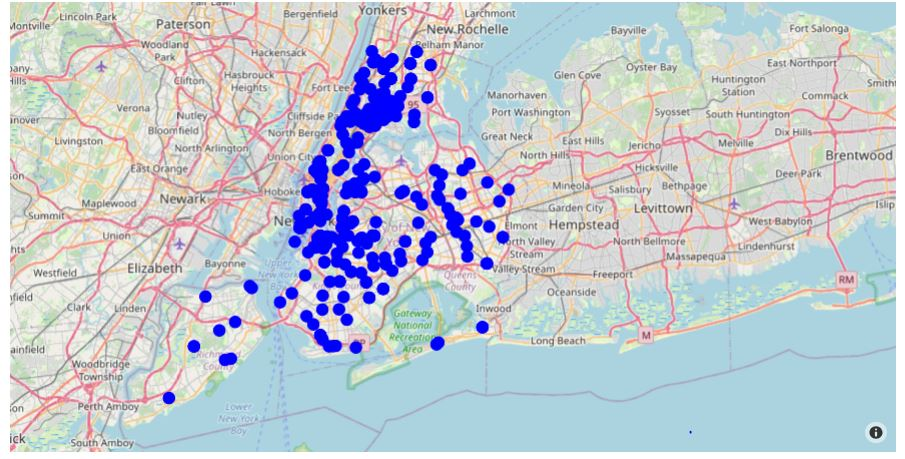

In [505]:
import plotly.express as px

In [506]:
fig = px.scatter_mapbox(combined, lat="lat", lon="lon", hover_name="School Name", hover_data=["total_ranking"],
                  color_discrete_sequence=["blue"], zoom=3, height=500) 
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker={'size': 15})
fig.show()

### Conclusion:

__BRONX:__ 

According to the map the two best schools are in the Bedford Park area of the Bronx. This may not be the cheapest area in the Bronx, but it is not the most expensive. Bedford Park lands in 12th most expensive out of the 36 neighborhoods with an average home price being $ 362,000.   

  

__QUEENS:__ 

According to the map the 2 of the best schools are located near Astoria and Long Island City. The 3rd best is in Jamacia. Jamaica is the lowest of the 3 neighborhoods when it comes to sales price making it the most affordable with the average home being 405,783. Long Island City and Astoria are on the higher end costing over $490,000.  

  

__BROOKLYN:__ 

The best schools in Brooklyn are scattered throughout the borough. A few are in less expensive neighborhoods, but Bushwick takes it with an average sales price of $435,873. This is the 4th lowest neighborhood in Brooklyn. Bushwick is also close to Williamsburg which holds another top school.   

  

__STATEN ISLAND:__ 

The best school in Staten Island is located near Oakwood. This neighborhood falls right in the average home price for the entire borough. Making this neighborhood not the best priced but a good choice since there is an A rated and B rated school roughly 7-8 city blocks away from each other.  

  

__MANHATTAN:__ 

The best schools in Manhattan are scattered throughout midtown and downtown Manhattan. These neighborhoods can range all over the scale for average home prices. The most notable is the High School of Mathematics and Science which is right outside the border of Harlem West. Harlem West has an average price of $ 920,000.  

  

The 5 boroughs have a robust public transportation system. Between trains and bus access commuting to school is always a possibility for the student. 